# Double-Layer Shallow Dome
#### March 2020, Amir Hossein Namadchi
This is an OpenSeesPy simulation of one of the numerical examples in our previously [published paper](https://ascelibrary.org/doi/abs/10.1061/%28ASCE%29EM.1943-7889.0001329). The Core was purely written in *Mathematica*. This is my attempt to perform the analysis again via Opensees Core, to see if I can get the similar results. In the paper, we used *Total Lagrangian* framework to model the structure. Unfortunately, OpenSees does not include this framework, so, alternatively, I will use Corotational truss element.


In [1]:
import numpy as np
import openseespy.opensees as ops
import matplotlib.pyplot as plt

Below, the base units are defined as python variables:

In [169]:
## Units
m = 1               # Meters
KN = 1              # KiloNewtons
s = 1               # Seconds

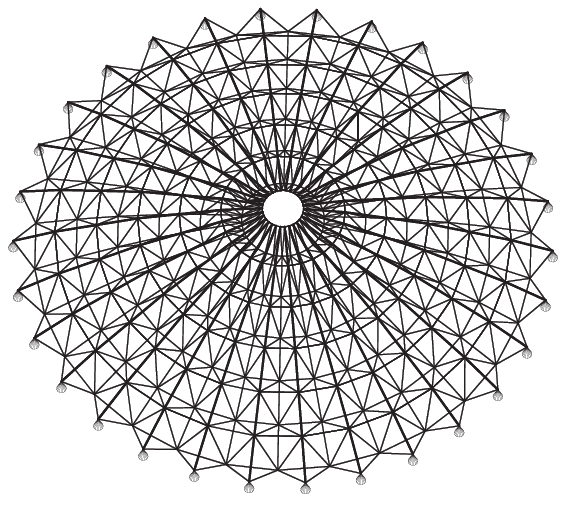

### Model Defintion
The coordinates information for each node are stored `node_coords`. Each row represent a node with the corresponding coordinates. Elements configuration are also described in `connectivity`, each row representing an element with its node IDs. Elements cross-sectional areas are stored in `area_list`. This appraoch, offers a more pythonic and flexible code when building the model. Since this is a relatively large model, some data will be read from external `.txt` files to keep the code cleaner.

In [97]:
# Node Coordinates Matrix (size : nn x 3)
node_coords = np.loadtxt('DLSDome/nodes.txt',
                         dtype = np.float64) * m

# Element Connectivity Matrix (size: nel x 2)
connectivity = np.loadtxt('DLSDome/connectivity.txt',
                          dtype = np.int64).tolist()

# Loaded Nodes
loaded_nodes = np.loadtxt('DLSDome/loaded_nodes.txt',
                          dtype = np.int64).tolist()

# Get Number of total Nodes
nn = len(node_coords)
# Get Number of total Elements
nel = len(connectivity)

# Cross-sectional area list (size: nel)
area_list = np.ones(nel)*(0.001)*(m**2)

# Modulus of Elasticity list (size: nel)
E_list = np.ones(nel)*(2.0*10**8)*(KN/m**2)

# Mass Density
rho = 7.850*((KN*s**2)/(m**4))

#Boundary Conditions (size: fixed_nodes x 4)
B_C = np.column_stack((np.arange(1,31),
                 np.ones((30,3), dtype = np.int64))
               ).tolist()

### Model Construction
I use <i>list comprehension</i> to add nodes,elements and other objects to the domain. 

In [164]:
ops.wipe()
ops.model('basic','-ndm',3,'-ndf',3)

# Adding nodes to the model object using list comprehensions
[ops.node(n+1,*node_coords[n]) for n in range(nn)];

# Applying BC
[ops.fix(B_C[n][0],*B_C[n][1:]) for n in range(len(B_C))];

# Set Material
ops.uniaxialMaterial('Elastic',1, E_list[0])

# Adding Elements
[ops.element('corotTruss', e+1, *connectivity[e], area_list[e],
             1,'-rho', rho*area_list[e], '-cMass', 1) for e in range(nel)];

* ### Eigenvalue Analysis
Let's get the first 6 periods of the structure to see if they coincide with the ones in paper.

In [165]:
eigenvalues = ops.eigen(6)
T_list = 2*np.pi/np.sqrt(eigenvalues)
print('The first 6 period of the structure are as follows:\n', T_list)

The first 6 period of the structure are as follows:
 [0.07189215 0.06809579 0.06809578 0.04648394 0.04648388 0.03117022]


* ### Dynamic Analysis
Great accordance is obtained in eigenvalue analysis. Now, let's do `wipeAnalysis()` and perform dynamic analysis. The Newmark time integration algorithm with $\gamma=0.5$ and $\beta=0.25$ (Constant Average Acceleration Algorithm) is used. Harmonic loads are applied vertically on the `loaded_nodes` nodes.


In [166]:
ops.wipeAnalysis()

# define load function
P = lambda t: 250*np.sin(250*t)

# Dynamic Analysis Parameters
dt = 0.00025
time = 0.2
time_domain = np.arange(0,time,dt)

# Adding loads to the domain beautifully
ops.timeSeries('Path', 1,
               '-dt', dt,
               '-values', *np.vectorize(P)(time_domain),
               '-time', *time_domain)
ops.pattern('Plain', 1, 1)
[ops.load(n, *[0,0,-1]) for n in loaded_nodes];

# Analysis
ops.constraints('Plain')
ops.numberer('Plain')
ops.system('ProfileSPD')
ops.test('NormUnbalance', 0.0000001, 100)
ops.algorithm('ModifiedNewton')
ops.integrator('Newmark', 0.5, 0.25)
ops.analysis('Transient')

In [167]:
time_lst =[]           # list to hold time stations for plotting
d_apex_list = []       # list to hold vertical displacments of the apex

for i in range(len(time_domain)):
    is_done = ops.analyze(1, dt)
    if is_done != 0:
        print('Failed to Converge!')
        break
    time_lst.append(ops.getTime())
    d_apex_list.append(ops.nodeDisp(362,3))

### Visualization
Below, the time history of the vertical displacement of the apex is plotted.

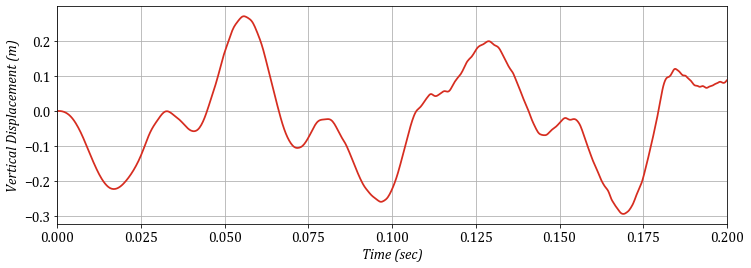

In [168]:
plt.figure(figsize=(12,4))
plt.plot(time_lst, np.array(d_apex_list), color = '#d62d20', linewidth=1.75)
plt.ylabel('Vertical Displacement (m)', {'fontname':'Cambria', 'fontstyle':'italic','size':14})
plt.xlabel('Time (sec)', {'fontname':'Cambria', 'fontstyle':'italic','size':14})
plt.xlim([0.0, time])
plt.grid()
plt.yticks(fontname = 'Cambria', fontsize = 14)
plt.xticks(fontname = 'Cambria', fontsize = 14);

### Closure
Very good agreements with the paper are obtained.
<blockquote>Namadchi, Amir Hossein, Farhang Fattahi, and Javad Alamatian. "Semiexplicit Unconditionally Stable Time Integration for Dynamic Analysis Based on Composite Scheme." Journal of Engineering Mechanics 143, no. 10 (2017): 04017119.</blockquote>
